**QUESTION:**

A simulated data set containing sales of child car seats at 400 different stores is given in the Carseats.csv file. 

a) Split the data into a training and test set

b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

c) Use cross-validation to determine the optimal level of tree complexity. 

d) Does pruning the tree improve the test MSE? (optional)

e) Use random forests to analyze the data. What test MSE do you obtain? Determine the most important variables and describe the effect of the number of variables considered in each split, on the error?

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/carseats/Carseats - Carseats.csv


In [25]:
# Import the necessary libraries

from sklearn import tree
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Read the data 

data=pd.read_csv("/kaggle/input/carseats/Carseats - Carseats.csv")
data.head()

,Unnamed: 0,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,5,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [4]:
# Remove the unnecessary columns

data=data.drop('Unnamed: 0',axis=1)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


In [6]:
# check for any missing values

missing_values = data.isna().sum()
print(missing_values)

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64


a) Split the data into a training and test set

In [7]:
# Split the data into features (X) and target variable (y)

X = data.drop("Sales", axis=1)
y = data["Sales"]

b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

In [8]:
categorical_cols = ['ShelveLoc','Urban','US']

# these are numeric predictors
numeric_cols = ['CompPrice','Income','Advertising','Population','Price','Age','Education']  

# one-hot encode the categorical variables
encoder = OneHotEncoder(sparse=False)
X_categorical = encoder.fit_transform(X[categorical_cols])
X_categorical = pd.DataFrame(X_categorical, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate the one-hot encoded categorical variables with the numeric variables
X_processed = pd.concat([X_categorical, X.drop(categorical_cols, axis=1)], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Fit the decision tree model
dtree = DecisionTreeRegressor()
dtree.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = dtree.predict(X_test)

# Calculate the test MSE
test_mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", test_mse)

Test MSE: 5.57924625


From the above output, the obtained test MSE for the DecisionTreeRegressor is 5.579.

We can visualize the tree using the export_graphviz function from the tree module.
This writes a file in the .dot file format, which is a text file format for storing graphs.
We set an option to color the nodes to reflect the majority class in each node and pass
the class and features names so the tree can be properly labeled:

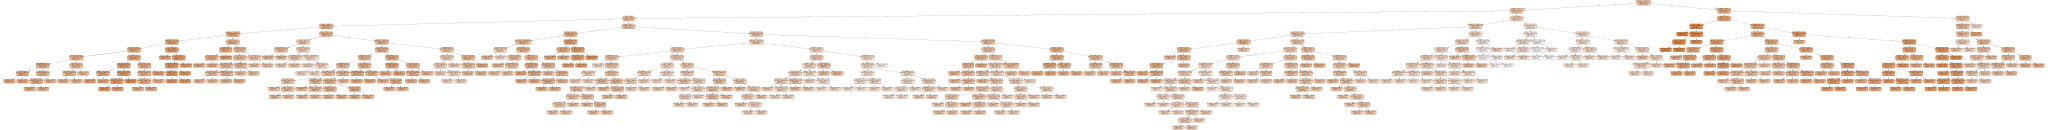

In [12]:
dot_data = export_graphviz(dtree, filled=True, rounded=True,  feature_names=['ShelveLoc_Bad',  'ShelveLoc_Good',  'ShelveLoc_Medium',  'Urban_No'  ,'Urban_Yes','US_No',  'US_Yes',  'CompPrice',  'Income',  'Advertising',  'Population',  'Price',  'Age','Education'],
                                                                             out_file="dot_data.dot")
with open("dot_data.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

The visualization of the tree provides a great in-depth view of how the algorithm
makes predictions, and is a good example of a machine learning algorithm that is
easily explained to nonexperts.

However,as seen here,the tree has become more complex due to over fitting of the data which leads to more nodes and depth. Deeper trees (a depth of 10 is not uncom‐
mon) are even harder to grasp. One method of inspecting the tree that may be helpful
is to find out which path most of the data actually takes.

c) Use cross-validation to determine the optimal level of tree complexity. 

d) Does pruning the tree improve the test MSE? (optional)

Typically, building a tree as described here and continuing until all leaves are pure
leads to models that are very complex and highly overfit to the training data. The
presence of pure leaves mean that a tree is 100% accurate on the training set.

There are two common strategies to prevent overfitting: stopping the creation of the
tree early (also called pre-pruning), or building the tree but then removing or collaps‐
ing nodes that contain little information (also called post-pruning or just pruning).
Possible criteria for pre-pruning include limiting the maximum depth of the tree,
limiting the maximum number of leaves, or requiring a minimum number of points
in a node to keep splitting it.

If we don’t restrict the depth of a decision tree, the tree can become arbitrarily deep
and complex. Unpruned trees are therefore prone to overfitting and not generalizing
well to new data. Now let’s apply pre-pruning to the tree, which will stop developing
the tree before we perfectly fit to the training data. One option is to stop building the
tree after a certain depth has been reached.

Here we will set the max_depth for the tree in the range of 20. Limiting the
depth of the tree decreases overfitting. This leads to a lower accuracy on the training
set, but an improvement on the test set.

we will use LOOCV for each depth and calculating the MSE for each set.


In [14]:
# Define a range of tree depths to test
tree_depths = range(1, 21)

# Perform LOOCV for each tree depth and calculate mean squared error (MSE)
cv_mse_scores = []
for depth in tree_depths:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    scores = cross_val_score(tree, X_train, y_train, cv=len(X_train), scoring='neg_mean_squared_error')
    cv_mse_scores.append(-scores.mean())

# Find the optimal tree depth with the lowest MSE
optimal_tree_depth = tree_depths[cv_mse_scores.index(min(cv_mse_scores))]

print("Optimal Tree Depth:", optimal_tree_depth)

Optimal Tree Depth: 6


In [15]:
print(min(cv_mse_scores))

4.322614370815048


From the above outputs, we can say that the optimal tree depth is 6 and its respective MSE score is 4.322 which reduced compared to the previous complex tree model.

e) Use random forests to analyze the data. What test MSE do you obtain? Determine the most important variables and describe the effect of the number of variables considered in each split, on the error?

In [16]:
# Create a random forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)

# Calculate the test MSE
test_mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Random Forest Test MSE:", test_mse_rf)

Random Forest Test MSE: 3.034168506624998


The test MSE for the RandomForestRegressor model is 3.03

Instead of looking at the whole tree, which can be taxing, there are some useful prop
erties that we can derive to summarize the workings of the tree. The most commonly
used summary is feature importance, which rates how important each feature is for
the decision a tree makes. It is a number between 0 and 1 for each feature, where 0
means “not used at all” and 1 means “perfectly predicts the target.” The feature
importances always sum to 1:

In [18]:
# printing the feature importance of all the features

rf.feature_importances_

array([0.06843275, 0.16915174, 0.0297654 , 0.00343353, 0.00405752,
       0.0027838 , 0.00261504, 0.0909107 , 0.05011068, 0.08552045,
       0.03847061, 0.30474621, 0.12119707, 0.0288045 ])

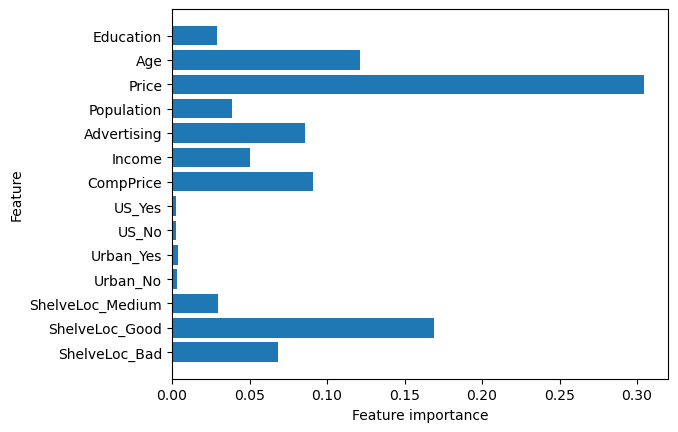

In [22]:
def plot_feature_importances(model):
    n_features = 14
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), ['ShelveLoc_Bad',  'ShelveLoc_Good',  'ShelveLoc_Medium',  'Urban_No'  ,'Urban_Yes','US_No',  'US_Yes',  'CompPrice',  'Income',  'Advertising',  'Population',  'Price',  'Age','Education'])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
plot_feature_importances(rf)


Here we see that the feature 'Price' is by far the most
important feature. This confirms that the 'Price' feature plays an important role in the Sales of carseats.
However, if a feature has a low feature_importance, it doesn’t mean that this feature
is uninformative. It only means that the feature was not picked by the tree, likely
because another feature encodes the same information.
In contrast to the coefficients in linear models, feature importances are always posi‐
tive, and don’t encode which class a feature is indicative of.